# Project Evaluation Criteria

## Data Loading and Preprocessing (2 points max)
- Load the data from the CSV files using the appropriate data import methods in PyTorch.
- Apply dataset splits that enable you to assess network overfitting.
- Preprocess the categorical and numerical data accordingly (refer to **Lesson 5 – Training Practices and Regularization** and **Lesson 6 – PyTorch in Production**).
- Make data loading protocols for mini-batch training.

## Approach and Methodology (2 points max)
- Implement a neural network architecture suited to the task and justify your choice (refer to **Lesson 6 – PyTorch in Production**).
- Apply regularization techniques that help prevent network overfitting.

## Results and Evaluation (2 points max)
- Build a training protocol to train your neural network on the dataset with a user-specified number of epochs.
- Implement methods that effectively regulate the training process (refer to **Lab 5 – Training Practices and Regularization**).
- Provide visualizations, if useful, that give an indication of the training procedure (e.g., a loss curve). These visualizations can be included in your report as part of your submission package.
- Implement a software method that saves the network’s weight with the best performance.  
  - These network weights should be saved as `.pt` / `.pth` file.
  - Include them as part of your submission package so that the teacher and the teaching assistant can reproduce your results. 

## Code Quality and Reproducibility (2 points max)
- Your code should be clean, well-structured, and properly commented.
- Ensure the code runs in inference mode with your network weights (`.pt` / `.pth` file) to produce the target variable (the number of rings) using the data from `test.csv`.
- Ensure that the model generates predictions for the number of rings for every data point in the test set.
- Write a `README` file for running your code in inference mode to produce the targets.  
  - This will help the teacher and the teaching assistant reproduce your results. 

## Summary and Justification (2 points max)
- Clearly summarize the key novelties of your approach.
- Justify the choices made in the data preprocessing, neural network design, training protocol, and inference protocol.
- Discuss any challenges encountered and potential improvements.

In [75]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
device, device_name = (torch.device("cuda"), torch.cuda.get_device_name(0)) if torch.cuda.is_available() else (torch.device("cpu"), "CPU")
print(f"Device: {device}, {device_name}")

Device: cpu, CPU


In [76]:
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

In [77]:
train_data

# check for missing values
train_data.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

In [78]:
test_data
# check for missing values
test_data.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
dtype: int64

In [79]:
# class AbaloneDataset(Dataset):
#     def __init__(self, csv_path, is_test=False):
#         self.data = pd.read_csv(csv_path)
#         self.is_test = is_test
#         self.preprocess_data()

#     def preprocess_data(self):
#         # One-hot encode 'Sex'
#         sex_mapping = {'M': 0, 'F': 1, 'I': 2}
#         self.data['Sex'] = self.data['Sex'].map(sex_mapping)
#         sex_one_hot = torch.nn.functional.one_hot(torch.tensor(self.data['Sex'].values), num_classes=3)

#         # Get numeric features
#         numeric_cols = [
#             'Length', 'Diameter', 'Height', 'Whole_weight',
#             'Shucked_weight', 'Viscera_weight', 'Shell_weight'
#         ]
#         numeric_data = torch.tensor(self.data[numeric_cols].values, dtype=torch.float32)

#         # Combine all features
#         self.features = torch.cat([sex_one_hot, numeric_data], dim=1)

#         # Targets
#         if not self.is_test:
#             self.targets = torch.tensor(self.data['Rings'].values, dtype=torch.float32).view(-1, 1)

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         if self.is_test:
#             return self.features[idx]
#         else:
#             return self.features[idx], self.targets[idx]

# train_dataset = AbaloneDataset('Data/train.csv')
# test_dataset = AbaloneDataset('Data/test.csv', is_test=True)

# for i in range(5):
#     print(test_dataset[i])


In [80]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class AbaloneDataset(Dataset):
    def __init__(self, csv_path, is_test=False, mean=None, std=None):
        self.data = pd.read_csv(csv_path)
        self.is_test = is_test

        # Define columns
        self.numeric_cols = [
            'Length', 'Diameter', 'Height', 'Whole_weight',
            'Shucked_weight', 'Viscera_weight', 'Shell_weight'
        ]
        self.sex_mapping = {'M': 0, 'F': 1, 'I': 2}

        # Compute or load mean and std for standardization
        if not is_test:
            self.mean = torch.tensor(self.data[self.numeric_cols].mean().values, dtype=torch.float32)
            self.std = torch.tensor(self.data[self.numeric_cols].std().values, dtype=torch.float32)
        else:
            self.mean = mean.clone().detach()
            self.std = std.clone().detach()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # One-hot encode 'Sex'
        sex_index = self.sex_mapping[row['Sex']]
        sex_one_hot = torch.nn.functional.one_hot(torch.tensor(sex_index), num_classes=3).float()

        # Get numeric features and standardize
        numeric = torch.tensor([row[col] for col in self.numeric_cols], dtype=torch.float32)
        numeric = (numeric - self.mean) / self.std

        # Combine features
        features = torch.cat([sex_one_hot, numeric])

        if self.is_test:
            return features
        else:
            target = torch.tensor(row['Rings'], dtype=torch.float32).view(1)
            return features, target



In [81]:
# Load full training dataset
full_train_dataset = AbaloneDataset("Data/train.csv")

# Save mean and std
mean = full_train_dataset.mean
std = full_train_dataset.std

# Split the full training dataset
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

# Re-wrap val_subset into a proper AbaloneDataset with the same mean/std
val_indices = val_subset.indices
val_df = full_train_dataset.data.iloc[val_indices].reset_index(drop=True)
val_df.to_csv("Data/val_temp.csv", index=False)
val_dataset = AbaloneDataset("Data/val_temp.csv", is_test=False, mean=mean, std=std)

# Test dataset (already correct)
test_dataset = AbaloneDataset("Data/test.csv", is_test=True, mean=mean, std=std)

for i in range(5):
    print(val_dataset[i])
print(len(val_dataset))

# Dataloaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(tensor([0.0000, 1.0000, 0.0000, 0.9848, 1.1146, 0.8658, 1.1099, 1.0527, 0.9769,
        1.3688]), tensor([20.]))
(tensor([0.0000, 1.0000, 0.0000, 0.9034, 1.1146, 0.8658, 1.0306, 1.2106, 1.0806,
        0.8516]), tensor([9.]))
(tensor([ 0.0000,  1.0000,  0.0000,  0.3330,  0.2738, -0.5504, -0.1033,  0.0527,
        -0.2940, -0.0863]), tensor([9.]))
(tensor([0.0000, 1.0000, 0.0000, 0.7404, 1.0651, 2.1531, 0.6419, 0.0351, 0.7218,
        1.0240]), tensor([23.]))
(tensor([ 1.0000,  0.0000,  0.0000, -0.6039, -0.6660, -0.4216, -0.8142, -0.8816,
        -0.6917, -0.7690]), tensor([12.]))
669


In [82]:
import torch

numeric_values = []

# Collect numeric features from first 500 samples
for i in range(500):
    features, _ = val_subset[i]
    numeric_part = features[3:]  # First 3 are one-hot encoded sex
    numeric_values.append(numeric_part)

# Stack into a single tensor
numeric_tensor = torch.stack(numeric_values)

# Check mean and std for each column
print("Column-wise mean:", numeric_tensor.mean(dim=0))
print("Column-wise std:", numeric_tensor.std(dim=0))

Column-wise mean: tensor([0.0227, 0.0179, 0.0499, 0.0340, 0.0205, 0.0387, 0.0360])
Column-wise std: tensor([1.0266, 1.0220, 1.0076, 1.0551, 1.0295, 1.0698, 1.0572])


In [83]:
class AbaloneNet(nn.Module):
    def __init__(self):
        super(AbaloneNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.model(x)

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AbaloneNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [85]:
train_losses = []
val_losses = []
patience = 5           # How many epochs to wait before stopping
counter = 0            # How many epochs since last improvement
best_val_loss = float('inf')

for epoch in range(1, 51):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

            val_preds.append(outputs.cpu())
            val_targets.append(targets.cpu())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_preds = torch.cat(val_preds)
    val_targets = torch.cat(val_targets)

    # Calculate additional metrics
    mae = F.l1_loss(val_preds, val_targets).item()
    rmse = torch.sqrt(F.mse_loss(val_preds, val_targets)).item()

    # Save for visualization
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Logging
    print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

    # Save best model 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        counter = 0  # Reset the early stopping counter
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")

        if counter >= patience:
            print("Early stopping triggered! ✅")
            break

Epoch 01 | Train Loss: 51.3450 | Val Loss: 9.0357 | MAE: 2.1218 | RMSE: 3.0059
Epoch 02 | Train Loss: 9.2624 | Val Loss: 6.5673 | MAE: 1.7662 | RMSE: 2.5627
Epoch 03 | Train Loss: 8.4727 | Val Loss: 5.9511 | MAE: 1.6665 | RMSE: 2.4395
Epoch 04 | Train Loss: 8.1092 | Val Loss: 5.9126 | MAE: 1.6251 | RMSE: 2.4316
Epoch 05 | Train Loss: 7.6127 | Val Loss: 5.4828 | MAE: 1.6147 | RMSE: 2.3415
Epoch 06 | Train Loss: 7.4262 | Val Loss: 5.3703 | MAE: 1.5986 | RMSE: 2.3174
Epoch 07 | Train Loss: 7.3999 | Val Loss: 5.3315 | MAE: 1.5777 | RMSE: 2.3090
Epoch 08 | Train Loss: 7.3988 | Val Loss: 5.5237 | MAE: 1.5894 | RMSE: 2.3503
No improvement in validation loss for 1 epoch(s).
Epoch 09 | Train Loss: 6.9342 | Val Loss: 5.2110 | MAE: 1.6219 | RMSE: 2.2828
Epoch 10 | Train Loss: 6.9810 | Val Loss: 5.6214 | MAE: 1.5710 | RMSE: 2.3709
No improvement in validation loss for 1 epoch(s).
Epoch 11 | Train Loss: 6.8049 | Val Loss: 4.9840 | MAE: 1.5186 | RMSE: 2.2325
Epoch 12 | Train Loss: 6.6940 | Val Loss:

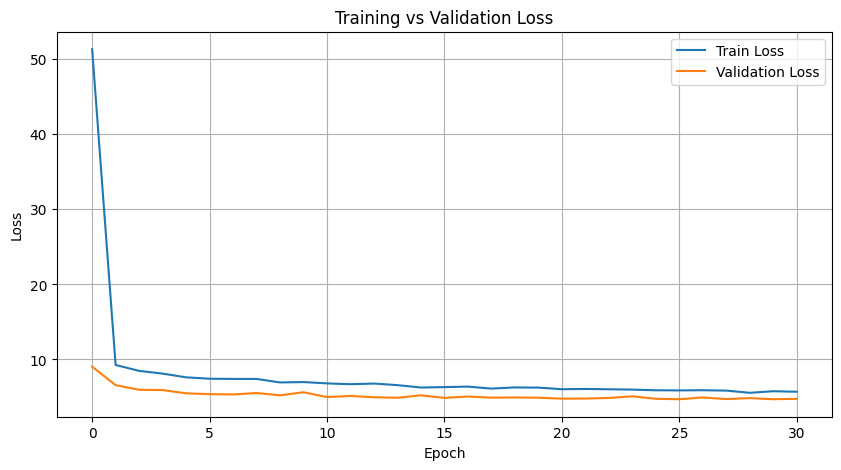

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [87]:
# Load model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Predict
predictions = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy().flatten())

# Save to CSV
test_df = pd.read_csv("Data/test.csv")
test_df["Rings"] = predictions
test_df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv ✅")

Saved test_predictions.csv ✅
